In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset,DataLoader,random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F

In [2]:
dataset = MNIST(root='data/',download=True,transform=ToTensor())

Text(0.5, 1.0, '1')

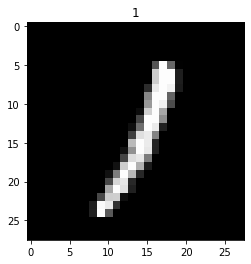

In [3]:
img,label = dataset[99]
plt.imshow(img[0],cmap='gray')
plt.title(str(label))

In [4]:
def Split_index(n,val_percent):
    n_val = int(val_percent*n)
    index = np.random.permutation(n)
    return index[n_val:],index[:n_val]

In [5]:
train_indices, val_indices = Split_index(len(dataset),val_percent=0.2)
print(len(train_indices),len(val_indices))
print(train_indices,val_indices)

48000 12000
[31484 42795 43382 ... 56870 29103 49600] [30276 53117 33147 ... 25991 32101 37980]


In [6]:
batch_size = 128

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_dl = DataLoader(dataset,batch_size =batch_size,sampler=train_sampler)
val_dl = DataLoader(dataset,batch_size =batch_size,sampler=val_sampler)

Images Shape :-  torch.Size([128, 1, 28, 28])


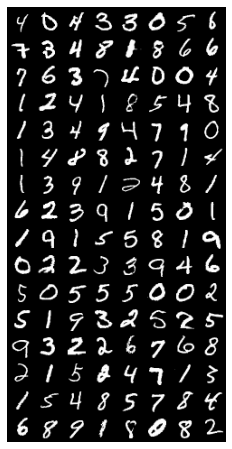

In [7]:
for images,_ in train_dl:
    print('Images Shape :- ',images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images,n_rows=16).permute((1,2,0)))
    break

In [8]:
torch.cuda.is_available()

True

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [12]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [14]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

In [16]:
for xb,yb in val_dl:
    print('xb device :- ',xb.device)
    print('yb :- ',yb)
    break

xb device :-  cuda:0
yb :-  tensor([0, 1, 4, 9, 2, 0, 2, 5, 1, 7, 9, 7, 7, 2, 3, 4, 4, 3, 8, 5, 4, 5, 8, 1,
        6, 8, 3, 9, 9, 2, 8, 3, 3, 7, 5, 7, 0, 6, 7, 9, 1, 7, 1, 4, 4, 0, 4, 1,
        8, 6, 3, 0, 5, 8, 2, 5, 4, 6, 1, 0, 0, 2, 2, 8, 5, 7, 9, 5, 3, 7, 3, 7,
        4, 7, 2, 5, 7, 9, 0, 9, 0, 7, 7, 4, 8, 6, 8, 2, 3, 1, 4, 1, 9, 9, 4, 8,
        8, 3, 3, 2, 3, 7, 9, 5, 3, 8, 1, 3, 5, 3, 6, 2, 6, 1, 6, 7, 9, 0, 7, 9,
        0, 3, 3, 7, 7, 1, 4, 7], device='cuda:0')


In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [18]:
class MNIST_ANN(nn.Module):
    def __init__(self,in_size,hidden_size,out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,out_size)
    
    def forward(self,xb):
        xb = xb.view(xb.size(0),-1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out

    def training_step(self,data):
        img, label = data
        out = self(img)
        loss = F.cross_entropy(out,label)
        return loss

    def validation_step(self,data):
        img,label = data
        out = self(img)
        loss = F.cross_entropy(out,label)
        acc = accuracy(out,label)
        return {'val_loss':loss, 'val_acc':acc}

    def validation_epoch_end(self,output):
        batch_losses = [x['val_loss'] for x in output]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_acc'] for x in output]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

    def epoch_end(self,epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        

In [19]:
t = torch.tensor([[[1,2,6],[3,4,6]],[[1,2,3],[1,2,3]]])
print(t.shape)
#t = t.view(t.size(0),-1)
#print(t.shape)
print(t.size(0))
print(t.view(-1))

torch.Size([2, 2, 3])
2
tensor([1, 2, 6, 3, 4, 6, 1, 2, 3, 1, 2, 3])


In [21]:
def evaluate(model,data):
    outputs = [model.validation_step(batch) for batch in data]
    return model.validation_epoch_end(outputs)        


In [26]:
def fit(Epochs,lr,model,train_dl,valid_dl,opt_fn=None):
    history = []
    optimizer = opt_fn(model.parameters(),lr=lr)
    for epoch in range(Epochs):
        for batch in train_dl:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model,valid_dl)
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [25]:
model = MNIST_ANN(28*28,hidden_size=100,out_size=10)
to_device(model,device)

MNIST_ANN(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)

In [29]:
histroy = fit(50,0.01,model,train_dl,val_dl,opt_fn=torch.optim.SGD)

Epoch [0], val_loss: 0.4166, val_acc: 0.8888
Epoch [1], val_loss: 0.3946, val_acc: 0.8931
Epoch [2], val_loss: 0.3787, val_acc: 0.8966
Epoch [3], val_loss: 0.3669, val_acc: 0.8997
Epoch [4], val_loss: 0.3565, val_acc: 0.9018
Epoch [5], val_loss: 0.3476, val_acc: 0.9033
Epoch [6], val_loss: 0.3402, val_acc: 0.9051
Epoch [7], val_loss: 0.3342, val_acc: 0.9067
Epoch [8], val_loss: 0.3264, val_acc: 0.9080
Epoch [9], val_loss: 0.3211, val_acc: 0.9102
Epoch [10], val_loss: 0.3161, val_acc: 0.9126
Epoch [11], val_loss: 0.3110, val_acc: 0.9140
Epoch [12], val_loss: 0.3060, val_acc: 0.9154
Epoch [13], val_loss: 0.3027, val_acc: 0.9163
Epoch [14], val_loss: 0.2980, val_acc: 0.9175
Epoch [15], val_loss: 0.2936, val_acc: 0.9184
Epoch [16], val_loss: 0.2890, val_acc: 0.9187
Epoch [17], val_loss: 0.2858, val_acc: 0.9198
Epoch [18], val_loss: 0.2817, val_acc: 0.9208
Epoch [19], val_loss: 0.2787, val_acc: 0.9217
Epoch [20], val_loss: 0.2750, val_acc: 0.9228
Epoch [21], val_loss: 0.2717, val_acc: 0.922

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

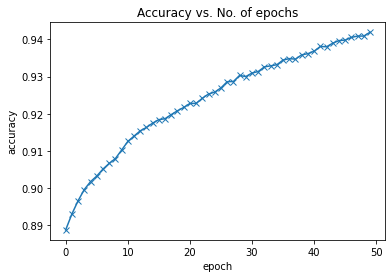

In [30]:
accuracies = [result['val_acc'] for result in histroy]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

In [31]:
torch.save(model.state_dict(),'mnist-DNN.pth')